### В этом проекте решается задача построения модели оценки кредитного риска

* исходные данные содержат информацию о клиентах в закодированном виде

* необходимо собрать итоговый датасет из предоставленных фйалов  
* смоделировать новые признаки и смержить с целевой переменной

* на подготовленных данных необходимо обучить несколько моделей и
* выбрать лучшую, критерием оценки является метрика ROC-AUC(показатель на  тесте не менее 0,75 )

* итоговый проект необходимо сохранить в виде файла в формате pickle.

In [ ]:
# путь до данных на компьютере
path = '../train_data/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightgbm
!pip install dask

In [ ]:
import os
import pandas as pd
import tqdm


def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)

def downcast_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Преобразует числовые типы данных в DataFrame на более компактные, такие как int8 и float32
    :param df: DataFrame для преобразования
    :return: DataFrame с уменьшенными типами данных
    """
    # Преобразование целочисленных типов
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')

    # Преобразование вещественных типов
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')

    return df

In [ ]:
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int = 50,
                                 save_to_path=None, verbose: bool = False) -> pd.DataFrame:
    """
    Возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи.
    :param path_to_dataset: str
        Путь до датасета с партициями.
    :param num_parts_to_preprocess_at_once: int
        Количество партиций, которые будут одновременно держаться и обрабатываться в памяти.
    :param num_parts_total: int
        Общее количество партиций, которые нужно обработать.
    :param save_to_path: str
        Путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён.
    :param verbose: bool
        Логирует каждую обрабатываемую часть данных.
    :return: pd.DataFrame с объединенными данными, если save_to_path не указан.
    """
    preprocessed_frames = []

    for step in tqdm.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)

        # Преобразование типов данных на более компактные
        transactions_frame = downcast_dtypes(transactions_frame)

        # Сохраняем обработанные данные на диск
        if save_to_path:
            block_as_str = str(step).zfill(3)
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)

    # Возвращаем объединенный DataFrame
    if not save_to_path:
        return pd.concat(preprocessed_frames).reset_index(drop=True)
    else:
        print(f"Все части данных обработаны и сохранены в {save_to_path}.")
        return None


In [ ]:
data = prepare_transactions_dataset(path, num_parts_to_preprocess_at_once=2, num_parts_total=12)

Transforming transactions data:   0%|          | 0/6 [00:00<?, ?it/s]

['../train_data/train_data_0.pq', '../train_data/train_data_1.pq', '../train_data/train_data_10.pq', '../train_data/train_data_11.pq', '../train_data/train_data_2.pq', '../train_data/train_data_3.pq', '../train_data/train_data_4.pq', '../train_data/train_data_5.pq', '../train_data/train_data_6.pq', '../train_data/train_data_7.pq', '../train_data/train_data_8.pq', '../train_data/train_data_9.pq', '../train_data/train_target.csv']


chunk_path ../train_data/train_data_0.pq


chunk_path ../train_data/train_data_1.pq


Transforming transactions data:  17%|█▋        | 1/6 [00:27<02:17, 27.42s/it]

['../train_data/train_data_0.pq', '../train_data/train_data_1.pq', '../train_data/train_data_10.pq', '../train_data/train_data_11.pq', '../train_data/train_data_2.pq', '../train_data/train_data_3.pq', '../train_data/train_data_4.pq', '../train_data/train_data_5.pq', '../train_data/train_data_6.pq', '../train_data/train_data_7.pq', '../train_data/train_data_8.pq', '../train_data/train_data_9.pq', '../train_data/train_target.csv']


chunk_path ../train_data/train_data_10.pq


chunk_path ../train_data/train_data_11.pq


Transforming transactions data:  33%|███▎      | 2/6 [00:58<01:58, 29.61s/it]

['../train_data/train_data_0.pq', '../train_data/train_data_1.pq', '../train_data/train_data_10.pq', '../train_data/train_data_11.pq', '../train_data/train_data_2.pq', '../train_data/train_data_3.pq', '../train_data/train_data_4.pq', '../train_data/train_data_5.pq', '../train_data/train_data_6.pq', '../train_data/train_data_7.pq', '../train_data/train_data_8.pq', '../train_data/train_data_9.pq', '../train_data/train_target.csv']


chunk_path ../train_data/train_data_2.pq


chunk_path ../train_data/train_data_3.pq


Transforming transactions data:  50%|█████     | 3/6 [01:26<01:27, 29.01s/it]

['../train_data/train_data_0.pq', '../train_data/train_data_1.pq', '../train_data/train_data_10.pq', '../train_data/train_data_11.pq', '../train_data/train_data_2.pq', '../train_data/train_data_3.pq', '../train_data/train_data_4.pq', '../train_data/train_data_5.pq', '../train_data/train_data_6.pq', '../train_data/train_data_7.pq', '../train_data/train_data_8.pq', '../train_data/train_data_9.pq', '../train_data/train_target.csv']


chunk_path ../train_data/train_data_4.pq


chunk_path ../train_data/train_data_5.pq


Transforming transactions data:  67%|██████▋   | 4/6 [01:56<00:58, 29.25s/it]

['../train_data/train_data_0.pq', '../train_data/train_data_1.pq', '../train_data/train_data_10.pq', '../train_data/train_data_11.pq', '../train_data/train_data_2.pq', '../train_data/train_data_3.pq', '../train_data/train_data_4.pq', '../train_data/train_data_5.pq', '../train_data/train_data_6.pq', '../train_data/train_data_7.pq', '../train_data/train_data_8.pq', '../train_data/train_data_9.pq', '../train_data/train_target.csv']


chunk_path ../train_data/train_data_6.pq


chunk_path ../train_data/train_data_7.pq


Transforming transactions data:  83%|████████▎ | 5/6 [02:27<00:29, 29.86s/it]

['../train_data/train_data_0.pq', '../train_data/train_data_1.pq', '../train_data/train_data_10.pq', '../train_data/train_data_11.pq', '../train_data/train_data_2.pq', '../train_data/train_data_3.pq', '../train_data/train_data_4.pq', '../train_data/train_data_5.pq', '../train_data/train_data_6.pq', '../train_data/train_data_7.pq', '../train_data/train_data_8.pq', '../train_data/train_data_9.pq', '../train_data/train_target.csv']


chunk_path ../train_data/train_data_8.pq


chunk_path ../train_data/train_data_9.pq


Transforming transactions data: 100%|██████████| 6/6 [03:02<00:00, 30.37s/it]


In [ ]:
# пример полученных данных
data.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [ ]:
# Выводим размер датасета
data.shape

(26162717, 61)

In [ ]:
# выводим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26162717 entries, 0 to 26162716
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int32
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19

In [ ]:
# Удаляем признаки, которых нет в ТЗ
data1 = data.drop(columns=['enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',])

In [ ]:
#выводим размер датасета
data1.shape

(26162717, 37)

In [ ]:
# Проверяем уникальные значения в признаке ID
data1.id.nunique()

3000000

In [ ]:
# Создаем новый признак is_delayed_closing, который показывает, был ли кредит закрыт позже планируемого срока
data1['is_delayed_closing'] = (data1['pre_till_fclose'] > data1['pre_till_pclose']).astype(int)
data1.shape

(26162717, 38)

In [ ]:
# Создаём признак общее количество флагов, указывающих на отсутствие просрочек
data1['total_overdue_flags'] = (
    data1['is_zero_loans5'] +
    data1['is_zero_loans530'] +
    data1['is_zero_loans3060'] +
    data1['is_zero_loans6090'] +
    data1['is_zero_loans90']
)
data1.shape

(26162717, 39)

In [ ]:
data1.shape

(26162717, 39)

In [ ]:
# Проверяем наличие дубликатов
data1.duplicated().sum()

0

In [ ]:
# Исследуем бинарные признаки
bin_cols = [n for n in data1.columns if data1[n].nunique() == 2]
for n in bin_cols:
    print(data1[n].value_counts(normalize=True), end='\n\n')

pre_loans_total_overdue
0    1.000000e+00
1    3.822233e-08
Name: proportion, dtype: float64

is_zero_loans5
1    0.918707
0    0.081293
Name: proportion, dtype: float64

is_zero_loans530
1    0.832211
0    0.167789
Name: proportion, dtype: float64

is_zero_loans3060
1    0.95736
0    0.04264
Name: proportion, dtype: float64

is_zero_loans6090
1    0.975431
0    0.024569
Name: proportion, dtype: float64

is_zero_loans90
1    0.976017
0    0.023983
Name: proportion, dtype: float64

is_zero_util
1    0.697866
0    0.302134
Name: proportion, dtype: float64

is_zero_over2limit
1    0.930116
0    0.069884
Name: proportion, dtype: float64

is_zero_maxover2limit
1    0.855567
0    0.144433
Name: proportion, dtype: float64

pclose_flag
0    0.850802
1    0.149198
Name: proportion, dtype: float64

fclose_flag
0    0.771032
1    0.228968
Name: proportion, dtype: float64

is_delayed_closing
1    0.546556
0    0.453444
Name: proportion, dtype: float64



Закодированные и бинаризованные признаки рассматриваем в качестве категориальных и кодируем через OHE. Таким образом каждое значение такого признака приобретает силу.

In [ ]:
# Создаём список для кодирования, исключаем признак ID, все небинаризованные и незакодированные, а также бинарные признаки.
cols_to_ohe = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding','pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate',
       'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'pre_util', 'pre_over2limit', 'pre_maxover2limit', 'enc_paym_0',
       'enc_loans_account_holder_type','enc_loans_credit_status', 'enc_loans_credit_type',
       'enc_loans_account_cur']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def process_columns_in_chunks(df, cols_to_ohe, chunk_size):
    """
    Применяет OneHotEncoder к колонкам в чанках с преобразованием в int8.

    :param df: исходный DataFrame
    :param cols_to_ohe: список колонок для OHE
    :param chunk_size: размер чанка
    :return: DataFrame с закодированными колонками
    """
    # Разделяем столбцы на чанки
    chunks = [cols_to_ohe[i:i + chunk_size] for i in range(0, len(cols_to_ohe), chunk_size)]

    # Список для хранения закодированных частей
    encoded_frames = []

    # Применяем OneHotEncoder к каждому чанку
    for chunk in chunks:
        # Создаем экземпляр OneHotEncoder
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

        # Выбираем подмножество столбцов
        df_chunk = df[chunk]

        # Применяем OneHotEncoder
        ohe_data = encoder.fit_transform(df_chunk)

        # Преобразуем данные в int8
        ohe_data = ohe_data.astype('int8')

        # Создаем DataFrame из закодированных данных
        feature_names = encoder.get_feature_names_out(chunk)
        df_encoded_chunk = pd.DataFrame(ohe_data, columns=feature_names)

        # Добавляем закодированный фрейм в список
        encoded_frames.append(df_encoded_chunk)

    # Объединяем все закодированные части в один DataFrame
    df_encoded = pd.concat(encoded_frames, axis=1)

    return df_encoded

# Применение функции
chunk_size = 2
df_encoded = process_columns_in_chunks(data1, cols_to_ohe, chunk_size)

print(df_encoded.head())

   pre_since_opened_1  pre_since_opened_2  pre_since_opened_3  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   pre_since_opened_4  pre_since_opened_5  pre_since_opened_6  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   1                   0                   0   
4                   0                   1                   0   

   pre_since_opened_7  pre_since_opened_8  pre_since_opened_9  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0  

In [ ]:
# Удаляем закодированные столбцы из исходного DataFrame
df_combined = data1.drop(columns=cols_to_ohe).reset_index(drop=True)

# Объединяем исходные данные с закодированными
df_combined = pd.concat([df_combined, df_encoded.reset_index(drop=True)], axis=1)

df_combined.head()

,id,rn,pre_loans_total_overdue,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,...,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3
0,0,1,0,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
1,0,2,0,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
2,0,3,0,1,1,1,1,1,0,1,...,0,0,1,0,0,0,0,1,0,0
3,0,4,0,0,1,1,1,1,1,1,...,1,0,0,0,0,0,0,1,0,0
4,0,5,0,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0


In [ ]:
df_combined.shape

(26162717, 292)

In [ ]:
# значения целевой переменной (смерджить с фичами по id)
targets = pd.read_csv('/content/drive/MyDrive/train_target.csv')
targets.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [ ]:
# Выводим размер датасета
targets.shape

(3000000, 2)

In [ ]:
# Проверяем количество уникальных ID
df_combined.id.nunique()

3000000

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq
# Создаем таблицу Arrow из DataFrame
table = pa.Table.from_pandas(df_combined)

# Сохраняем таблицу в файл Parquet
pa.parquet.write_table(table,'ohe.parquet')


Т.к. один заёмщик мог взять несколько кредитных продуктов, то делаем группировку по ID с агрегацией по сумме

In [ ]:
# Загружаем файл
import dask.dataframe as dd
data_dask = dd.read_parquet('ohe.parquet', engine='pyarrow', blocksize='10MB')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
nrows, ncols = data_dask.shape

# Вычисляем количество строк
nrows_computed = nrows.compute()
ncols_computed = ncols

print(f"Number of rows: {nrows_computed}")
print(f"Number of columns: {ncols_computed}")

Number of rows: 26162717
Number of columns: 292


In [ ]:
# Выполняем группировку по ID c агрегацией по сумме
import dask.dataframe as dd

def aggregate_in_parts(df_dask, chunk_size):
    partitions = df_dask.to_delayed()
    results = []

    for partition in partitions:
        # Выполняем агрегацию на уровне чанка
        aggregated = partition.groupby('id').sum()
        results.append(aggregated)

    # Объединяем результаты
    combined_results = dd.from_delayed(results).groupby('id').sum()
    return combined_results

chunk_size = 100
data2 = aggregate_in_parts(data_dask, chunk_size)

# Вычисление результата и сброс индекса
data2_computed = data2.compute().reset_index()

print(data2_computed.shape)

(3000000, 292)


In [ ]:
data2_computed.head()

,id,rn,pre_loans_total_overdue,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,...,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3
0,0,55,0,9,10,10,10,10,6,9,...,1,0,2,7,0,0,0,10,0,0
1,1,105,0,12,10,12,12,11,10,12,...,3,0,3,8,0,0,0,14,0,0
2,2,6,0,3,2,2,2,3,1,3,...,0,0,2,1,0,0,0,3,0,0
3,3,120,0,15,15,15,15,15,8,14,...,1,0,4,9,1,0,0,15,0,0
4,4,1,0,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
# Объединяем датасеты
merged_data = pd.merge(targets, data2_computed, on='id')
merged_data.shape

(3000000, 293)

In [ ]:
merged_data.head()

,id,flag,rn,pre_loans_total_overdue,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,...,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3
0,0,0,55,0,9,10,10,10,10,6,...,1,0,2,7,0,0,0,10,0,0
1,1,0,105,0,12,10,12,12,11,10,...,3,0,3,8,0,0,0,14,0,0
2,2,0,6,0,3,2,2,2,3,1,...,0,0,2,1,0,0,0,3,0,0
3,3,0,120,0,15,15,15,15,15,8,...,1,0,4,9,1,0,0,15,0,0
4,4,0,1,0,1,1,1,1,1,1,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
# Сохраняем итоговый датафрейм в CSV файл
merged_data.to_csv('data_final.csv', index=False)

### EDA

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import(
                         cross_val_predict,
                         RandomizedSearchCV,
                         cross_val_score,
                         train_test_split)
from lightgbm import LGBMClassifier
from sklearn.metrics import(
                        ConfusionMatrixDisplay,
                        make_scorer,
                        roc_auc_score,
                        roc_curve,
                        classification_report,
                        confusion_matrix)
from sklearn.utils import resample

from sklearn.pipeline import Pipeline

from sklearn.ensemble import(
                     GradientBoostingClassifier,
                     RandomForestClassifier)

from scipy.stats import(
                    shapiro,
                    kruskal)
import warnings

In [2]:
# Настройки
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


# оформление — скрытие предупреждений
warnings.filterwarnings("ignore")

# константы
RS = 42 # RANDOM_STATE

In [3]:
df = pd.read_csv('../train_data/data_final.csv')

In [4]:
def get_info(data):
    '''
    Возвращает основную информацию о датасете
    '''
    print(f'Основные показатели датасета:')
    print('-'*40)
    print(f'Количество признаков: {data.shape[1]}')
    print('-'*40)
    print(f'Количество сэмплов: {data.shape[0]}')
    print('-'*40,end='\n\n')
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    print('-'*40,end='\n\n')
    print('Пример данных:')
    display(data.head(3))

get_info(df)

Основные показатели датасета:
----------------------------------------
Количество признаков: 293
----------------------------------------
Количество сэмплов: 3000000
----------------------------------------

Количество дубликатов: 0
----------------------------------------

Пример данных:


,id,flag,rn,pre_loans_total_overdue,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag,is_delayed_closing,total_overdue_flags,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_15,pre_since_confirmed_16,pre_since_confirmed_17,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_5,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_4,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_till_fclose_10,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_outstanding_2,pre_loans_outstanding_3,pre_loans_outstanding_4,pre_loans_outstanding_5,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rate_10,pre_loans_credit_cost_rate_11,pre_loans_credit_cost_rate_12,pre_loans_credit_cost_rate_13,pre_loans5_1,pre_loans5_2,pre_loans5_3,pre_loans5_5,pre_loans5_6,pre_loans5_7,pre_loans5_8,pre_loans5_9,pre_loans5_10,pre_loans5_11,pre_loans5_13,pre_loans5_16,pre_loans530_1,pre_loans530_2,pre_loans530_3,pre_loans530_4,pre_loans530_5,pre_loans530_6,pre_loans530_7,pre_loans530_8,pre_loans530_9,pre_loans530_10,pre_loans530_11,pre_loans530_12,pre_loans530_13,pre_loans530_14,pre_loans530_15,pre_loans530_16,pre_loans530_17,pre_loans530_18,pre_loans530_19,pre_loans3060_1,pre_loans3060_2,pre_loans3060_3,pre_loans3060_4,pre_loans3060_5,pre_loans3060_6,pre_loans3060_7,pre_loans3060_8,pre_loans3060_9,pre_loans6090_1,pre_loans6090_2,pre_loans6090_3,pre_loans6090_4,pre_loans90_3,pre_loans90_8,pre_loans90_10,pre_loans90_13,pre_loans90_14,pre_loans90_19,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_

In [ ]:
def calculate_missing_data(data):

    # Вывод основной информации о DataFrame
    data.info()

    # Расчет пропусков и процентов пропусков
    missing_data = data.isna().sum()
    missing_percent = (missing_data / len(data)) * 100
    missing_percent = missing_percent.round(2)

    missing_info = pd.DataFrame({
        'Пропуски': missing_data,
        'Процент пропусков': missing_percent
    })

    return missing_info

calculate_missing_data(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 293 entries, id to enc_loans_account_cur_3
dtypes: int64(293)
memory usage: 6.5 GB


,Пропуски,Процент пропусков
id,0,0.0
flag,0,0.0
rn,0,0.0
pre_loans_total_overdue,0,0.0
is_zero_loans5,0,0.0
is_zero_loans530,0,0.0
is_zero_loans3060,0,0.0
is_zero_loans6090,0,0.0
is_zero_loans90,0,0.0
is_zero_util,0,0.0


Датасет не содержит дубликатов и пропущенных значений.

#### Исследуем целевой признак

flag
0    2893558
1     106442
Name: count, dtype: int64

Процент значений 1: 3.55%
Процент значений 0: 96.45%


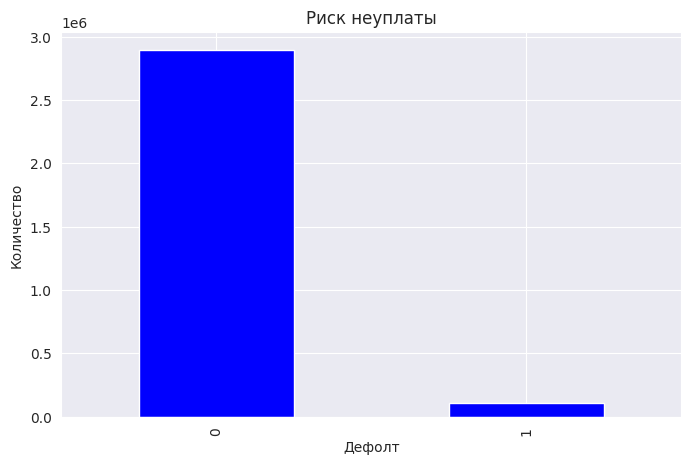

In [ ]:
# Проверяем баланс значений в признаке
print(df['flag'].value_counts())

# Подсчет количества значений
count_1 = df['flag'].sum()
count_0 = len(df) - count_1
percent_1 = (count_1 / len(df)) * 100
percent_0 = (count_0 / len(df)) * 100
print(f'\nПроцент значений 1: {percent_1:.2f}%\nПроцент значений 0: {percent_0:.2f}%')

# Подсчет количества значений без учета пола
count_by_class = df['flag'].value_counts().sort_index()

# Построение столбчатой диаграммы
count_by_class.plot(kind='bar', color=['blue'], figsize=(8, 5))
plt.title('Риск неуплаты')
plt.xlabel('Дефолт')
plt.ylabel('Количество')
plt.show()

Наблюдаем дисбаланс классов, минорный класс слабо представлен, составляет 3,55% от общего количества

In [ ]:
# Исследуем бинарные признаки
bin_cols = [n for n in df.columns if df[n].nunique() == 2]
for n in bin_cols:
    print(df[n].value_counts(normalize=True), end='\n\n')

flag
0    0.964519
1    0.035481
Name: proportion, dtype: float64

pre_loans_total_overdue
0    9.999997e-01
1    3.333333e-07
Name: proportion, dtype: float64

pre_loans5_8
0    0.999989
1    0.000011
Name: proportion, dtype: float64

pre_loans5_10
0    9.999997e-01
1    3.333333e-07
Name: proportion, dtype: float64

pre_loans5_11
0    0.999999
1    0.000001
Name: proportion, dtype: float64

pre_loans530_1
0    0.999954
1    0.000046
Name: proportion, dtype: float64

pre_loans530_5
0    0.999998
1    0.000002
Name: proportion, dtype: float64

pre_loans530_7
0    0.99999
1    0.00001
Name: proportion, dtype: float64

pre_loans530_8
0    0.999999
1    0.000001
Name: proportion, dtype: float64

pre_loans530_9
0    0.999999
1    0.000001
Name: proportion, dtype: float64

pre_loans530_10
0    0.99997
1    0.00003
Name: proportion, dtype: float64

pre_loans530_11
0    0.999995
1    0.000005
Name: proportion, dtype: float64

pre_loans530_14
0    0.999888
1    0.000112
Name: proportion, dtype

In [ ]:
def find_univariate_features(data):
    """
    Функция для нахождения признаков с единственным уникальным значением в DataFrame.

    """
    univariate_features = []

    for column in data.columns:
        # Проверка, содержит ли столбец только одно уникальное значение
        if data[column].nunique() == 1:
            univariate_features.append(column)

    return univariate_features

In [ ]:
univariate_columns = find_univariate_features(df)
print("Признаки с единственным уникальным значением:", univariate_columns)

Признаки с единственным уникальным значением: []


Одномерных признаков в датасете нет.

### Статистический анализ

Проверим признаки на нормальность их распределения, для этого используем тест Шапиро-Уилка.

In [ ]:
# Создаём датасет для тесте Шапиро-Уилка, исключим бинарные признаки
shapiro_data = df.drop(columns=bin_cols)

In [ ]:
def apply_shapiro_test(df):
    """
    Функция для проведения теста Шапиро-Уилка
    """
    results = {}
    alpha = 0.05
    # выбираем колонки только с числовым значением для теста Шапиро_Уилка
    for column in df.select_dtypes(include=['number']).columns:
        # Удаление пропущенных значений
        clean_data = df[column].dropna()

        # Проверка, достаточно ли данных для выполнения теста
        if len(clean_data) > 3:  # тест требует как минимум 3 наблюдения
            stat, p = shapiro(clean_data)
            results[column] = {'W-statistic': stat, 'p-value': p}

            if p > alpha:
                results[column]['normality'] = "Нулевая гипотеза не отвергается (данные имеют нормальное распределение)"
            else:
                results[column]['normality'] = "Нулевая гипотеза отвергается (данные не имеют нормального распределения)"
        else:
            results[column] = {'W-statistic': None, 'p-value': None, 'normality': "Недостаточно данных для выполнения теста"}

    return results

In [ ]:
# Проводим тест Шапиро-Уилка, проверяем нормальность распределения числовых признаков
shapiro_results = apply_shapiro_test(shapiro_data)

for column, result in shapiro_results.items():
    print(f"Признак '{column}':")
    print(f"  W-statistic: {result['W-statistic']}")
    print(f"  p-value: {result['p-value']}")
    print(f"  Normality: {result['normality']}\n")

Признак 'id':
  W-statistic: 0.9549297875793735
  p-value: 3.239267208558468e-138
  Normality: Нулевая гипотеза отвергается (данные не имеют нормального распределения)

Признак 'rn':
  W-statistic: 0.7298192113865226
  p-value: 7.829696543542309e-199
  Normality: Нулевая гипотеза отвергается (данные не имеют нормального распределения)

Признак 'is_zero_loans5':
  W-statistic: 0.9200568136997525
  p-value: 2.100630156421252e-156
  Normality: Нулевая гипотеза отвергается (данные не имеют нормального распределения)

Признак 'is_zero_loans530':
  W-statistic: 0.9102919078698861
  p-value: 3.367978400031004e-160
  Normality: Нулевая гипотеза отвергается (данные не имеют нормального распределения)

Признак 'is_zero_loans3060':
  W-statistic: 0.9194498613551687
  p-value: 1.1876633420206162e-156
  Normality: Нулевая гипотеза отвергается (данные не имеют нормального распределения)

Признак 'is_zero_loans6090':
  W-statistic: 0.9209698372638121
  p-value: 4.989738919162929e-156
  Normality: Нул

### Применяем статтест для выявления зависимости фичей от таргета

Тест Краскела-Уоллиса является непараметрическим тестом, т.к. данные не имеют нормального распределения, используем его. Он работает с рангами данных вместо самих данных.

In [ ]:
def apply_kruskal(df, group_col):
    """
    Функция для проведения теста Краскела-Уоллиса
    """
    results = {}
    alpha = 0.05

    numerical_cols = df.select_dtypes(include=['number']).columns

    groups_dict = {val: df[df[group_col] == val] for val in df[group_col].unique()}

    for col in numerical_cols:
        if col == group_col:
            continue

        groups = [groups_dict[val][col].dropna() for val in groups_dict]

        stat, p = kruskal(*groups)
        results[col] = {'H-statistic': stat, 'p-value': p}

        if p < alpha:
            decision = "Нулевая гипотеза отвергается (различия статистически значимы)"
        else:
            decision = "Нулевая гипотеза не отвергается (различия не статистически значимы)"

        results[col]['Decision'] = decision

    return results

In [ ]:
# Применение функции для проведения теста Краскела-Уоллиса
kruskal_results = apply_kruskal(df, 'flag')

# Вывод результатов
for col, result in kruskal_results.items():
    print(f"Признак '{col}':")
    print(f"  H-statistic: {result['H-statistic']}")
    print(f"  p-value: {result['p-value']}")
    print(f"  Decision: {result['Decision']}\n")

Признак 'id':
  H-statistic: 0.004013633355498314
  p-value: 0.9494852193645043
  Decision: Нулевая гипотеза не отвергается (различия не статистически значимы)

Признак 'rn':
  H-statistic: 1438.23642467886
  p-value: 0.0
  Decision: Нулевая гипотеза отвергается (различия статистически значимы)

Признак 'pre_loans_total_overdue':
  H-statistic: 27.183452373075202
  p-value: 1.850356335768659e-07
  Decision: Нулевая гипотеза отвергается (различия статистически значимы)

Признак 'is_zero_loans5':
  H-statistic: 2324.807565263693
  p-value: 0.0
  Decision: Нулевая гипотеза отвергается (различия статистически значимы)

Признак 'is_zero_loans530':
  H-statistic: 4590.317389816542
  p-value: 0.0
  Decision: Нулевая гипотеза отвергается (различия статистически значимы)

Признак 'is_zero_loans3060':
  H-statistic: 3067.0754036279636
  p-value: 0.0
  Decision: Нулевая гипотеза отвергается (различия статистически значимы)

Признак 'is_zero_loans6090':
  H-statistic: 2538.547201347775
  p-value: 

Признаки имеют ненормальное распределение. Удаление признаков, которые по статтесту были определены как "различия не статистически значимы", не оказало положительного влияния на скор.

In [5]:
# Удаляем признак ID, он неинформативен для модели
df.drop('id', axis=1, inplace=True)

In [6]:
# Удаляем признак rn, который является порядковым номером крединого продукта
df.drop('rn', axis=1, inplace=True)
df.shape

(3000000, 291)

### Разделение датасета

In [7]:
# Изменение типа данных int64 на int8 для сокращения объёма используемой памяти
df[df.select_dtypes(['int64']).columns] = df.select_dtypes(['int64']).astype('int8')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 291 entries, flag to enc_loans_account_cur_3
dtypes: int8(291)
memory usage: 832.6 MB


In [9]:
target = df['flag']
features = df.drop('flag', axis=1)

### Применяем даунсэмплинг к тренировочной выборке, т.к. данные имеют сильный дисбаланс классов.

In [10]:
# Разделение выборок в пропорции 70/30
df_train, df_test = train_test_split(
    df, stratify=df['flag'], test_size=0.3, random_state=RS
)

In [11]:
df_min = df_train[df_train['flag'] == 1]
df_maj = df_train[df_train['flag'] == 0]

df_maj_downsample = resample(df_maj, replace=False, n_samples=len(df_min), random_state=RS)

print(df_maj_downsample.shape)
print(df_min.shape)

(74509, 291)
(74509, 291)


In [12]:
df_2 = pd.concat([df_maj_downsample, df_min], ignore_index=True).sample(frac=1.)

In [13]:
df_2.shape

(149018, 291)

In [14]:
# Разделение выборок
X_train = df_2.drop('flag', axis=1)
y_train = df_2['flag']

X_test = df_test.drop('flag', axis=1)
y_test = df_test['flag']

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(149018, 290)
(900000, 290)
(149018,)
(900000,)


### Обучаем модели на тренировочной выборке с подбором гиперпараметров и `RandomizedSearchCV`, применяем кросс-валидацию на 5 фолдов

In [ ]:
%%time
# Определение модели
model = RandomForestClassifier(random_state=RS)

# Словарь с гиперпараметрами для настройки
param_grid = {
    'n_estimators': list(range(50, 200, 30)),
    'min_samples_leaf': list(range(1, 6, 1)),
    'max_depth': list(np.linspace(10, 40, 5, dtype=int)),
    'criterion': ['gini', 'entropy']
}

# Определение метрики для поиска
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Настройка RandomizedSearchCV
grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring=scorer,
    error_score='raise',
    random_state=RS,
    n_jobs=-1
)

# Обучение модели
grid.fit(X_train, y_train)

# Получение лучшей модели
best_model_rf = grid.best_estimator_

# Предсказания вероятностей на тренировочных данных с использованием кросс-валидации
y_pred_proba = cross_val_predict(best_model_rf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Оценка ROC-AUC на тренировочных данных
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'ROC-AUC на кросс-валидации: {roc_auc:.4f}')

# Вывод лучших параметров
best_params_rf = grid.best_params_
print('Параметры лучшей модели:', best_params_rf)


ROC-AUC на кросс-валидации: 0.7424
Параметры лучшей модели: {'n_estimators': 170, 'min_samples_leaf': 4, 'max_depth': 25, 'criterion': 'entropy'}
CPU times: user 8min 51s, sys: 28.3 s, total: 9min 19s
Wall time: 14min 16s


ROC-AUC на тестовых данных: 0.7413

Classification Report для RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80    868067
           1       0.07      0.68      0.13     31933

    accuracy                           0.68    900000
   macro avg       0.53      0.68      0.46    900000
weighted avg       0.95      0.68      0.78    900000


Confusion Matrix для RandomForestClassifier:


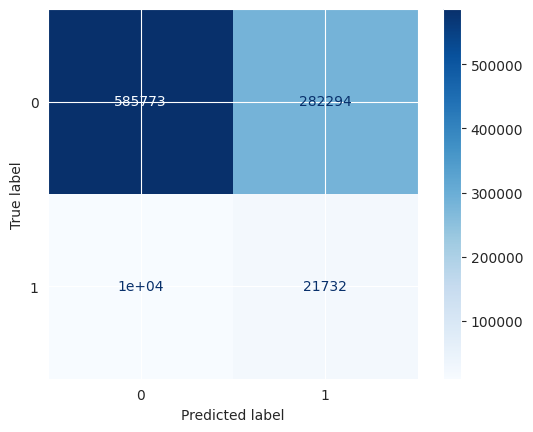

In [ ]:
# Оценка на тестовых данных
y_test_pred_proba = best_model_rf.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f'ROC-AUC на тестовых данных: {roc_auc_test:.4f}')

y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

report_rf = classification_report(y_test, y_test_pred)
print('\nClassification Report для RandomForestClassifier:')
print(report_rf)

print('\nConfusion Matrix для RandomForestClassifier:')
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [16]:
%%time
# Определение модели
model = GradientBoostingClassifier(random_state=RS)

param_grid = [
    {
        'loss': ["log_loss"],
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'min_samples_leaf': [50, 100],
        'max_features': [0.3, 0.5]
    }
]
# Определение метрики для поиска
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Настройка RandomizedSearchCV
grid1 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring=scorer,
    error_score='raise',
    random_state=RS,
    n_jobs=-1
)

# Обучение модели
grid1.fit(X_train, y_train)

# Получение лучшей модели
best_model_gb = grid1.best_estimator_

# Предсказания вероятностей на тренировочных данных с использованием кросс-валидации
y_pred_proba = cross_val_predict(best_model_gb, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Оценка ROC-AUC на тренировочных данных
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'ROC-AUC на кросс-валидации: {roc_auc:.4f}')

# Вывод лучших параметров
best_params_gb = grid1.best_params_
print('Параметры лучшей модели:', best_params_gb)

ROC-AUC на кросс-валидации: 0.7488
Параметры лучшей модели: {'n_estimators': 200, 'min_samples_leaf': 100, 'max_features': 0.5, 'max_depth': 5, 'loss': 'log_loss', 'learning_rate': 0.1}
CPU times: total: 12min 26s
Wall time: 3h 21min 6s


ROC-AUC на тестовых данных: 0.7483

Classification Report для GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    868067
           1       0.07      0.69      0.13     31933

    accuracy                           0.68    900000
   macro avg       0.53      0.68      0.47    900000
weighted avg       0.95      0.68      0.78    900000


Confusion Matrix для GradientBoostingClassifier:


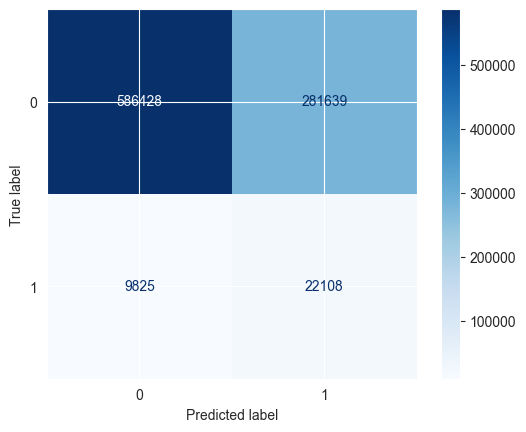

In [17]:
# Оценка на тестовых данных
y_test_pred_proba_gb = best_model_gb.predict_proba(X_test)[:, 1]
roc_auc_test_gb = roc_auc_score(y_test, y_test_pred_proba_gb)

print(f'ROC-AUC на тестовых данных: {roc_auc_test_gb:.4f}')

y_test_pred_gb = (y_test_pred_proba_gb >= 0.5).astype(int)

report_gb = classification_report(y_test, y_test_pred_gb)
print('\nClassification Report для GradientBoostingClassifier:')
print(report_gb)

print('\nConfusion Matrix для GradientBoostingClassifier:')
cm = confusion_matrix(y_test, y_test_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
%%time
# Определение модели
model = LGBMClassifier(random_state=RS, boosting_type='gbdt', verbose=-100)

# Словарь с гиперпараметрами для настройки
param_grid = {
    'num_leaves': [8, 16, 32, 64, 128, 256],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'min_child_samples': [5, 10, 20, 30, 40],
    'reg_alpha': [0.0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.01, 0.1, 0.5, 1.0],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Определение метрики для поиска
scorer = make_scorer(roc_auc_score, needs_proba=True)

# Настройка RandomizedSearchCV
grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring=scorer,
    error_score='raise',
    random_state=RS,
    n_jobs=-1
)

# Обучение модели
grid.fit(X_train, y_train)

# Получение лучшей модели
best_model_lgbm = grid.best_estimator_

# Предсказания вероятностей на тренировочных данных с использованием кросс-валидации
y_pred_proba = cross_val_predict(best_model_lgbm, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Оценка ROC-AUC на тренировочных данных
roc_auc = roc_auc_score(y_train, y_pred_proba)
print(f'ROC-AUC на кросс-валидации: {roc_auc:.4f}')

# Вывод лучших параметров
best_params_lgbm = grid.best_params_
print('Параметры лучшей модели:', best_params_lgbm)

ROC-AUC на кросс-валидации: 0.7520
Параметры лучшей модели: {'subsample': 0.7, 'reg_lambda': 0.0, 'reg_alpha': 0.5, 'num_leaves': 64, 'n_estimators': 500, 'min_child_samples': 40, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
CPU times: total: 5min 46s
Wall time: 18min 47s


ROC-AUC на тестовых данных: 0.7520

Classification Report для LGBMClassifier:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80    868067
           1       0.07      0.70      0.13     31933

    accuracy                           0.68    900000
   macro avg       0.53      0.69      0.47    900000
weighted avg       0.95      0.68      0.78    900000


Confusion Matrix для LGBMClassifier:


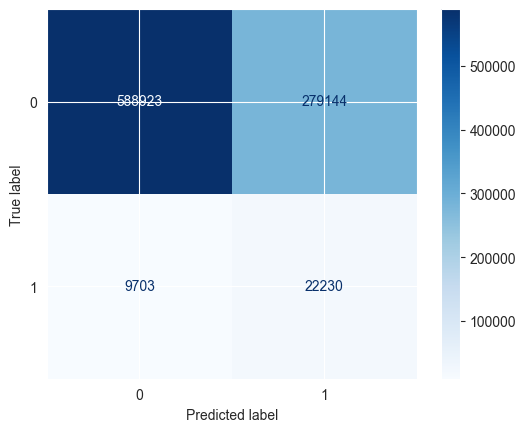

In [16]:
# Оценка на тестовых данных
y_test_pred_proba_lgbm = best_model_lgbm.predict_proba(X_test)[:, 1]
roc_auc_test_lgbm = roc_auc_score(y_test, y_test_pred_proba_lgbm)

print(f'ROC-AUC на тестовых данных: {roc_auc_test_lgbm:.4f}')

y_test_pred_lgbm = (y_test_pred_proba_lgbm >= 0.5).astype(int)

report_lgbm = classification_report(y_test, y_test_pred_lgbm)
print('\nClassification Report для LGBMClassifier:')
print(report_lgbm)

print('\nConfusion Matrix для LGBMClassifier:')
cm = confusion_matrix(y_test, y_test_pred_lgbm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Лучшей моделью оказалась `LGBMClassifier` с результатом метрики `ROC-AUC`на кросс-валидации 75,20% и на тестовой выборке 75,20% (значение метрики между трейном и тестом составляет 0%, что говорит о хорошей обобщающей способности модели, модель стабильно работает на разных подвыборках данных и её производительность предсказуема). Выведем важность признаков для лучшей модели и построим график ROC-кривой.

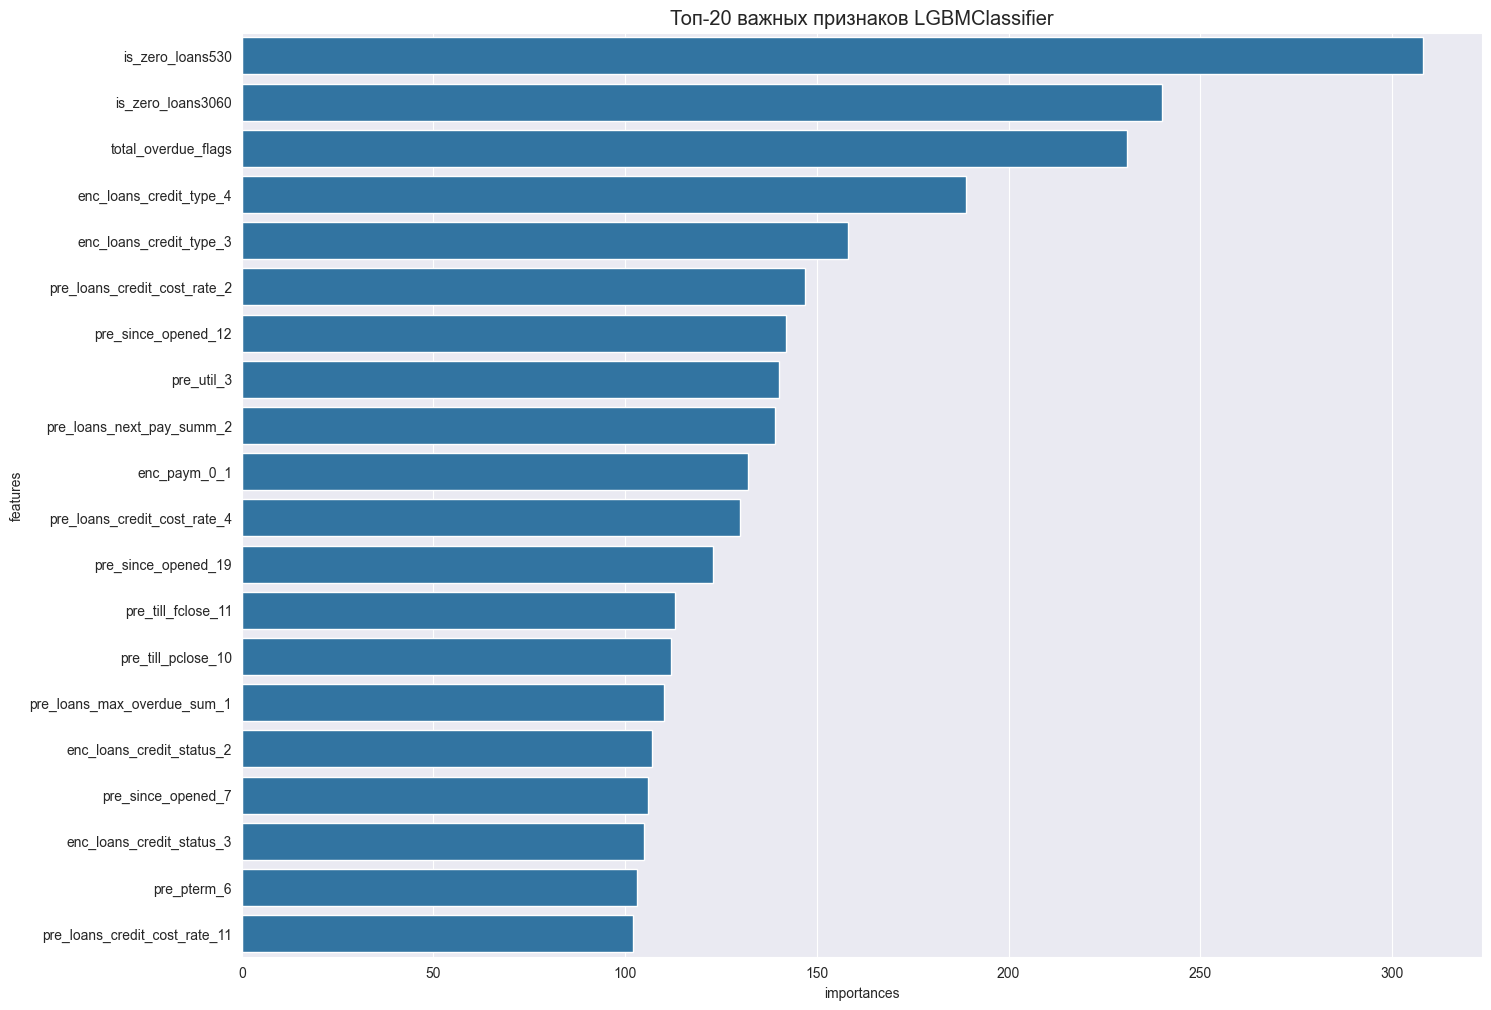

In [17]:
# Важность признаков
feature_importance = pd.DataFrame({
    'features': X_train.columns,
    'importances': best_model_lgbm.feature_importances_
})

# Отображаем только те признаки, важность которых больше 0
feature_importance = feature_importance[feature_importance['importances'] > 0]

# Сортировка по важности признаков и выбор топ-20
feature_importance.sort_values(by='importances', ascending=False, inplace=True)
top_20_features = feature_importance.head(20)

# Построение графика для топ-20 признаков
plt.figure(figsize=(16, 12))
sns.barplot(data=top_20_features, x='importances', y='features')
plt.title('Топ-20 важных признаков LGBMClassifier', fontsize='x-large')
plt.show()

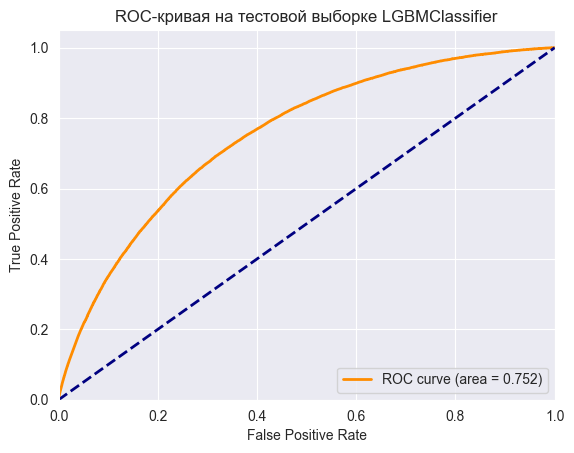

In [18]:
# Построение графика ROC-кривой на тестовой выборке
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lgbm)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_lgbm:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая на тестовой выборке LGBMClassifier')
plt.legend(loc="lower right")
plt.show()

### Интерпретация матрицы ошибок для модели LGBMClassifier

True Positives (TP) (22 230): Это случаи, когда модель правильно предсказала дефолт, что полезно для идентификации рискованных клиентов.

False Positives (FP) (279 144): Это клиенты, которых модель ошибочно классифицировала как дефолтные, хотя они на самом деле вернули кредит. Эти ошибки могут привести к потерям в бизнесе, если их используют для отказа в кредитовании.

False Negatives (FN) (9 703): Это клиенты, которых модель ошибочно классифицировала как надежных, но они на самом деле не вернули кредит. Эти ошибки особенно опасны, так как они означают пропущенные риски.

True Negatives (TN) (588 923): Это клиенты, которых модель правильно предсказала как надежных.

Выводы

False Negatives (FN) — наибольшая угроза, так как они означают пропущенные риски (дефолтные клиенты, которых модель не смогла идентифицировать).

False Positives (FP) — также нежелательны, так как они могут привести к отказам в кредитовании надежных клиентов.

Значения FN и FP наименьшие у модели  LGBMClassifier в сравнении с другими моделями.

### Сохранение модели

In [19]:
# обучаем лучшую модель на всем датасете
best_model_lgbm.fit(features, target)

LGBMClassifier(colsample_bytree=0.7, max_depth=5, min_child_samples=40,
               n_estimators=500, num_leaves=64, random_state=42, reg_alpha=0.5,
               subsample=0.7, verbose=-100)

In [20]:
import pickle
# Финализируем работу, сохраняем в файл .pickle
filename = 'final_lgbm.pickle'

with open(filename, 'wb') as file:
  pickle.dump(best_model_lgbm, file)

### Проверка сохраненной модели

In [21]:
# Проверяем сохраненный файл
with open('final_lgbm.pickle', 'rb') as file:
 fin_model = pickle.load(file)

In [22]:
# Проверяем модель
fin_model

LGBMClassifier(colsample_bytree=0.7, max_depth=5, min_child_samples=40,
               n_estimators=500, num_leaves=64, random_state=42, reg_alpha=0.5,
               subsample=0.7, verbose=-100)

In [24]:
%%time
# С помощью нашей модели делаем предсказание на одной строке датасета
df = pd.read_csv('../train_data/data_final.csv')

CPU times: total: 17.3 s
Wall time: 1min 31s


In [25]:
# Берем рандомную строку исходного датасета
row = df.sample(1)
row_x = row.drop(['flag'], axis=1)
row_y = row['flag']

In [27]:
# Удаляем признаки из датасета, как при обучении модели
row_x = row_x.drop(columns=['id', 'rn'], errors='ignore')

# Проверяем количество признаков после удаления
print(f"Количество признаков для предсказания: {row_x.shape[1]}")

Количество признаков для предсказания: 290


In [28]:
#%%time
# вызываем predict нашей модели
fin_model.predict(row_x)

array([0], dtype=int8)

In [29]:
# Сравним с реальным значением этой строки
row_y

2677419    0
Name: flag, dtype: int64

* МОДЕЛЬ РАБОТАЕТ И ПРЕДСКАЗАЛА ЗНАЧЕНИЕ ВЕРНО !